# EDA Notebook - Exploring bmarket dataset

## Part 1 - Data Loading and initial EDA
---
Purpose
- Convert data to a pandas DataFrame
- Identify features and target column
- Get a feel for the structure of the data before column specific EDA

---

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

In [ ]:
import sqlite3

conn = sqlite3.connect("data/01_raw/bmarket.db")
cursor = conn.cursor()

# sqlite_master exists in all sqlite databases and contains metadata on all tables
cursor.execute("SELECT name FROM sqlite_master")
rows = cursor.fetchall()
for row in rows:
    print(row)

('bank_marketing',)


In [ ]:
import pandas as pd

# There's only a singular table, convert it to DataFrame
# From the head, it looks like Subscription Status is the target column
df = pd.read_sql("SELECT * FROM bank_marketing", conn)
df.head()

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


In [ ]:
# Null values only in two columns, but quite a significant amount in housing loan especially
# age should be converted to integer type in cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB


Subscription Status
no     0.887346
yes    0.112654
Name: count, dtype: float64

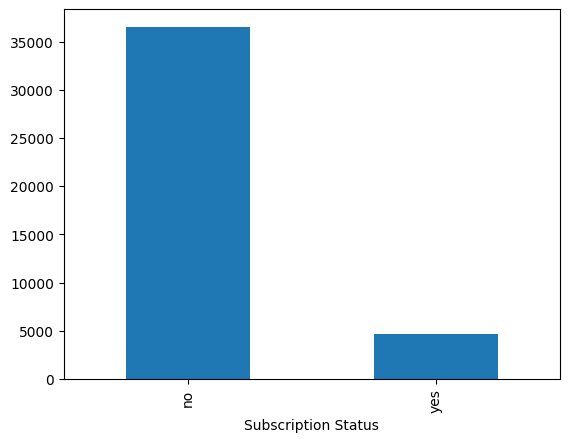

In [ ]:
# Very heavy class imbalance
df['Subscription Status'].value_counts().plot(kind='bar')
df['Subscription Status'].value_counts()/df.shape[0]

## Part 2a - Data Cleaning: Darren's Part
---
Purpose
- Go column-by-column to explore and understand each feature
- Determine all cleaning to be performed in the Kedro pipeline

---

### Initial Simple Data Cleaning

In [ ]:
# Renaming all columns to a format without spaces
column_renames = {name : name.lower().replace(" ", "_") for name in df.columns}
df_renamed = df.rename(columns=column_renames)
df_renamed.columns

Index(['client_id', 'age', 'occupation', 'marital_status', 'education_level',
       'credit_default', 'housing_loan', 'personal_loan', 'contact_method',
       'campaign_calls', 'previous_contact_days', 'subscription_status'],
      dtype='object')

In [ ]:
# Dropping the Client ID column
# This data is not needed because ID should not have any actual correlation with subscription status (only coincidental)
df_dropid = df_renamed.drop("client_id", axis=1) 
df_dropid.head(3)

,age,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no


### Age
---
Unrealistic 150 year old outliers (likely data entry errors) found
- Converted column to integer type and stripped 'years' unit
- Set to -1 and added an extra column denoting if the age was unknown or not (boolean)
---

In [ ]:
# AGE
# Conversion from string to int type
df_age = df_dropid.copy()
df_age.age = df_age.age.map(lambda x: int(x.split(" ")[0]))

print(f"Number of null values in age column: {df_age.age.isna().sum()}")    # Checking for any empty age cells
df_age.dtypes

Number of null values in age column: 0


age                       int64
occupation               object
marital_status           object
education_level          object
credit_default           object
housing_loan             object
personal_loan            object
contact_method           object
campaign_calls            int64
previous_contact_days     int64
subscription_status      object
dtype: object

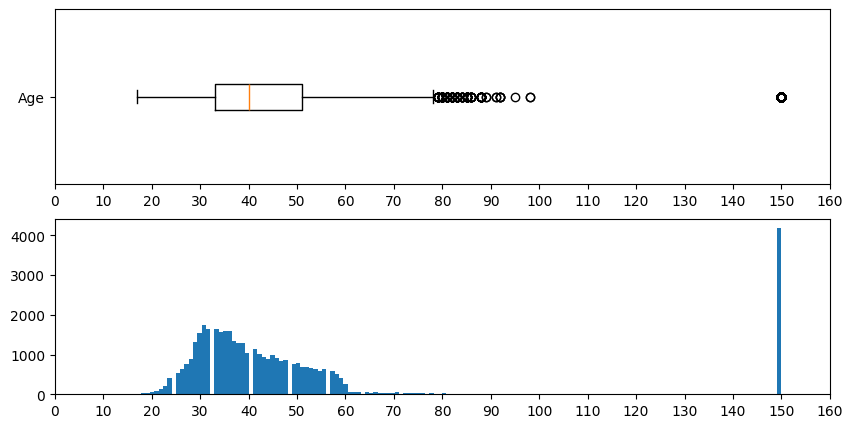

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].boxplot(df_age.age, vert=False, tick_labels=["Age"])
ax[0].set_xticks(range(0, 161, 10))
ax[1].hist(df_age.age, bins=150)
ax[1].set_xticks(range(0, 161, 10))
plt.show()

Histogram shows a large number of outliers with age = 150, this is likely a data input error
2 solutions: Either clip to max age (~90 years old) or set them as unknown values (-1). 

In this case, it would be best to set them as unknown, since clipping the values would skew the dataset toward the max age,
and ruin the distribution of ages in this dataset.

Solution: Set all ages = 150 (outliers) to -1, Create a new boolean column denoting that the age is unknown

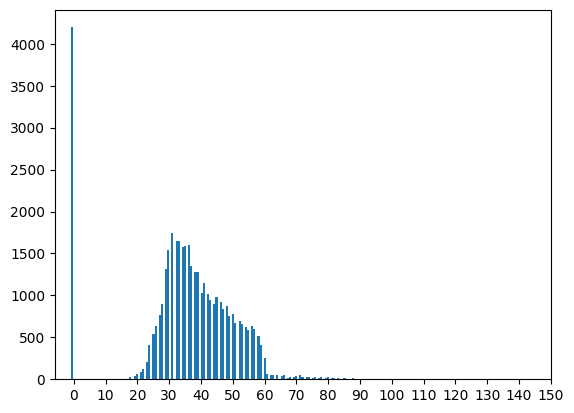

,age,age_unk
0,57,False
1,55,False
2,33,False
3,36,False
4,27,False


In [ ]:
df_age.age = df_age.age.map(lambda x: x if x != 150 else -1)     # Set >90 years old to -1
df_age.insert(loc=df_age.columns.get_loc("age")+1, column="age_unk", value=df_age.age.map(lambda x: True if x == -1 else False))

plt.hist(df_age.age, bins=150)
plt.xticks(range(0, 151, 10))
plt.show()

df_age.loc[:, ["age", "age_unk"]].head()

### Occupation
---
Normal, no cleaning required

---

In [ ]:
df_job = df_age.copy()
df_job.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


Number of null values in occupation column: 0
occupation
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64


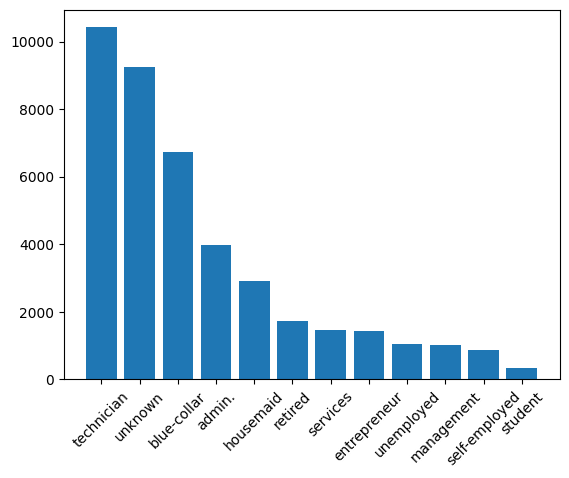

In [ ]:
print(f"Number of null values in occupation column: {df_job.occupation.isna().sum()}")
print(df_job.occupation.value_counts())
plt.bar(df_job.occupation.unique(), df_job.occupation.value_counts())
plt.xticks(rotation=45)
plt.show()

### Education Level
---
Normal, no cleaning required

Rare category: illiterate, with only 18 instances in entire dataset

---

In [ ]:
df_education = df_job.copy()
df_education.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


Number of null values in education_level column: 0
education_level
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64


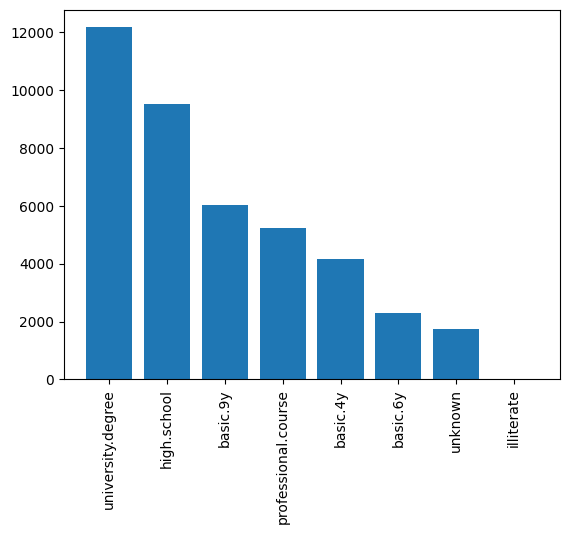

In [ ]:
# Unique values of education level show no overlap in categorization, so no change is necessary
# No nulls found
# Small problem with the extremely small amount of data on illiterate education level, but otherwise there is nothing serious that needs to be cleaned.
print(f"Number of null values in education_level column: {df_education.education_level.isna().sum()}")
print(df_education.education_level.value_counts())
plt.bar(df_education.education_level.value_counts().index, df_education.education_level.value_counts().values)
plt.xticks(rotation=90)
plt.show()

### Contact Method
---
Categorization overlap: Cell = cellular & Telephone = telephone
- Combined categories (Cell & cellular -> cellular, Telephone & telephone -> telephone)

---

In [ ]:
df_contact = df_education.copy()
df_contact.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,Cell,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,Cell,2,999,no


In [ ]:
# No nulls found
# Categorization overlap with Cell -> cellular & Telephone -> telephone
print(f"Number of null values in contact_method column: {df_contact.contact_method.isna().sum()}")
print(_ := df_contact.contact_method.value_counts())
print(f"\nCellular Category total: {_.iloc[:2].sum()}\nTelephone Category total: {_.iloc[2:].sum()}")

Number of null values in contact_method column: 0
contact_method
Cell         13100
cellular     13044
Telephone     7585
telephone     7459
Name: count, dtype: int64

Cellular Category total: 26144
Telephone Category total: 15044


In [ ]:
# Combining Cell -> cellular & Telephone -> telephone
df_contact.contact_method = df_contact.contact_method.map(lambda x: "cellular" if x[0].lower() == "c" else "telephone")
print(df_contact.contact_method.value_counts())

contact_method
cellular     26144
telephone    15044
Name: count, dtype: int64


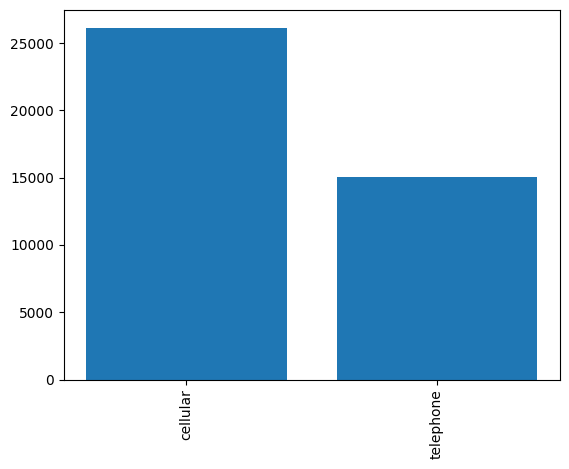

In [ ]:
plt.bar(df_contact.contact_method.unique(), df_contact.contact_method.value_counts())
plt.xticks(rotation=90)
plt.show()

### Campaign Calls
---
Campaign Calls data sometimes represented with negative numbers (not possible)
- Used K-S test to prove distribution similarity between negative and positive space numbers
- Assume negative numbers is a data entry error where a proportion of positive numbers were converted by accident
- Abs on Campaign Calls columns

---

In [ ]:
df_campaign = df_contact.copy()
df_campaign.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,cellular,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,cellular,2,999,no


In [ ]:
# No null values
# It looks like campaign calls goes into the negatives, despite it not being possible to have negative campaign calls
print(f"Number of null values in contact_method column: {df_contact.contact_method.isna().sum()}")
df_campaign.campaign_calls.describe()

Number of null values in contact_method column: 0


count    41188.000000
mean         2.051374
std          3.171345
min        -41.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign_calls, dtype: float64

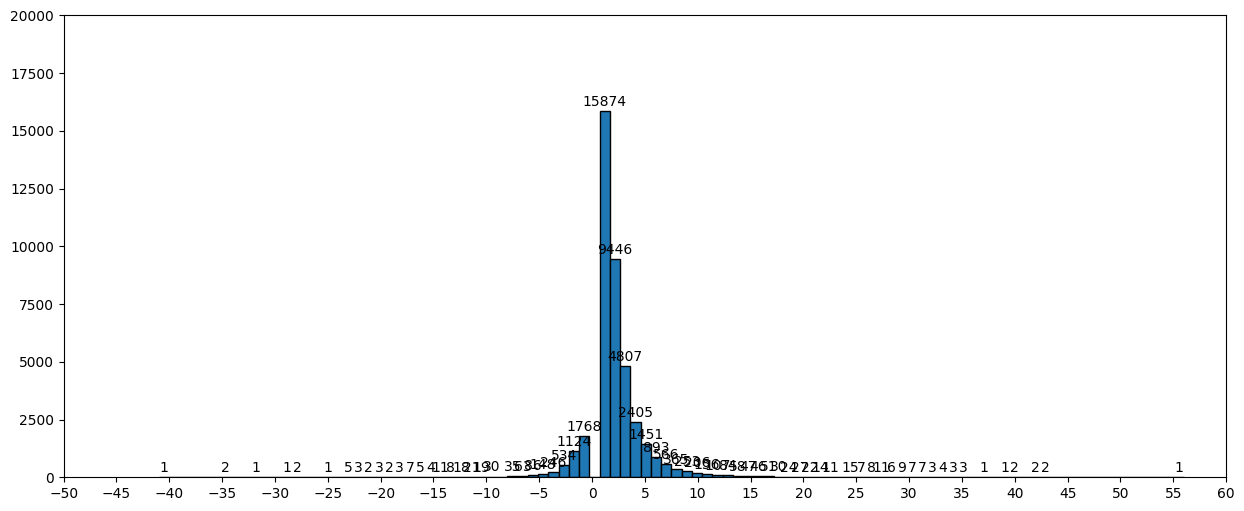

In [ ]:
plt.figure(figsize=(15, 6))
counts, bins, patches = plt.hist(df_campaign.campaign_calls, bins=100, edgecolor='black')
# Add value labels
for count, bin_edge in zip(counts, bins[:-1]):
    if count > 0:
        plt.text(bin_edge + (bins[1] - bins[0]) / 2, count+100, str(int(count)), ha='center', va='bottom')
plt.xticks(range(-50, 61, 5))
plt.axis([-50, 60, 0, 20000])
plt.show()

In [ ]:
print("Count of negative values: ", end="")
print(len(df_campaign[df_campaign.campaign_calls < 0]))

Count of negative values: 4153


Based on the histogram, you can see many of the values are in the negatives, despite these values not being possible for this data column.
3 Solutions:
    1. Clip negative values to 0 / lowest campaign calls values > 0
    2. Change all negative values into unknown values
    3. Assume this is a data entry error where positive data was mistakenly changed to negative values

Solution 1: 
    Clipping the negative values will create skewed data, since the histogram already shows that the data is more frequent the smaller the number is.
    Additional ~4,000 data points would be added to the most frequent category, which may negatively affect the generalisation of the final model.

Solution 2:
    Changing all negative values into unknown values will result in losing ~4,000 data points, which can affect the model's ability

Solution 3:
    Based on the histogram above, it does seem that a portion of the positive values were accidentally converted into negative values,
    since the overall distribution in the negative space is similar to that of the positive space.
    Additionally, converting the data this way would allow us to prevent any data loss which would have been caused by the previous solutions.
    The only problem is that this distribution similarity between positive and negative may be coincidental. 

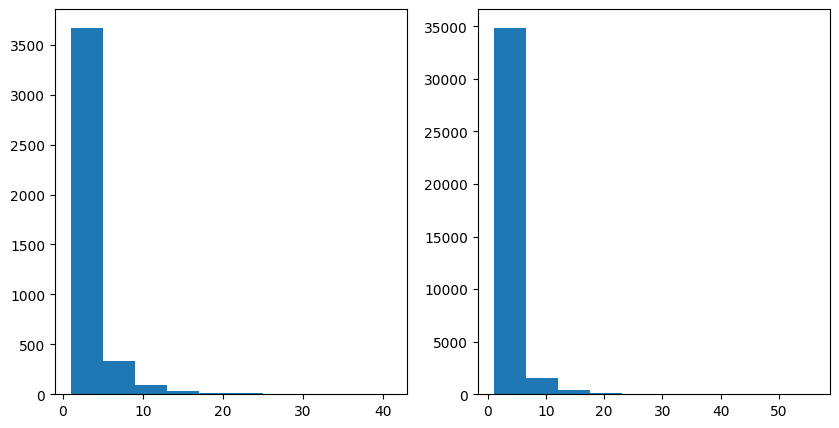

In [ ]:
# Calculating similarity of positive and negative space distributions using K-S test
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Negative space
ax[0].hist(neg := df_campaign.campaign_calls[df_campaign.campaign_calls < 0].abs())
# Positive space
ax[1].hist(pos := df_campaign.campaign_calls[df_campaign.campaign_calls > 0])
plt.show()

In [ ]:
statistic, p = stats.ks_2samp(neg, pos)
print("K-S Test for samples neg & pos:")
print(f"KS Stat:    {statistic}")
print(f"p-value:    {p}")

K-S Test for samples neg & pos:
KS Stat:    0.012686471895130724
p-value:    0.5804227545723576


Explanation & Thought Process:

The hypothesis here is that the negative numbers inside the dataset (negative sample), are errors that are caused by accidentally
converting a portion of the positive numbers into negative numbers. This hypothesis can be proven if both the negative and positive
samples are likely taken from the same distribution. In order to do this, I will use the 2 sample Kolmogorov-Smirnov (K-S) Test 
which is used to determine if two samples come from the same distribution. This will be calculated using scipy.stats.ks_2samp()

The Kolmogorov-Smirnov (KS) test defines two hypotheses:

Null Hypothesis: Samples are taken from the same distribution

Alternative Hypothesis: Samples are taken from different distributions

If the p-value <= alpha (0.05, the standard significance level) the null hypothesis is rejected and the samples have different
distributions. If the p-value > alpha, the null hypothesis cannot be rejected and it is likely that the two samples come from
the same distribution. Additionally, the D statistic shows the maximium distance between the Cumulative Density Function (CDF)
curves. A smaller D statistic and higher p-value typically suggests similar distributions.


Application:

I separated the campaign_calls column into two separate samples, one which contains only the positive values and one that only
contains the negative values absoluted to be put in the positive space. Then I calculated the D statistic and p-value using
2 sample K-S test to determine the distribution similarity.

As a result, I obtained the p-value of ~0.5804 which is larger than the alpha / standard significance level of 0.05. Which means that
I cannot decisively reject the null hypothesis. I also obtained a D statistic of ~0.01268. With both the low D statistic and the high p-value it is safe to say that the negative space and positive space campaign_calls data values are likely taken from the same distribution. 

count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign_calls, dtype: float64


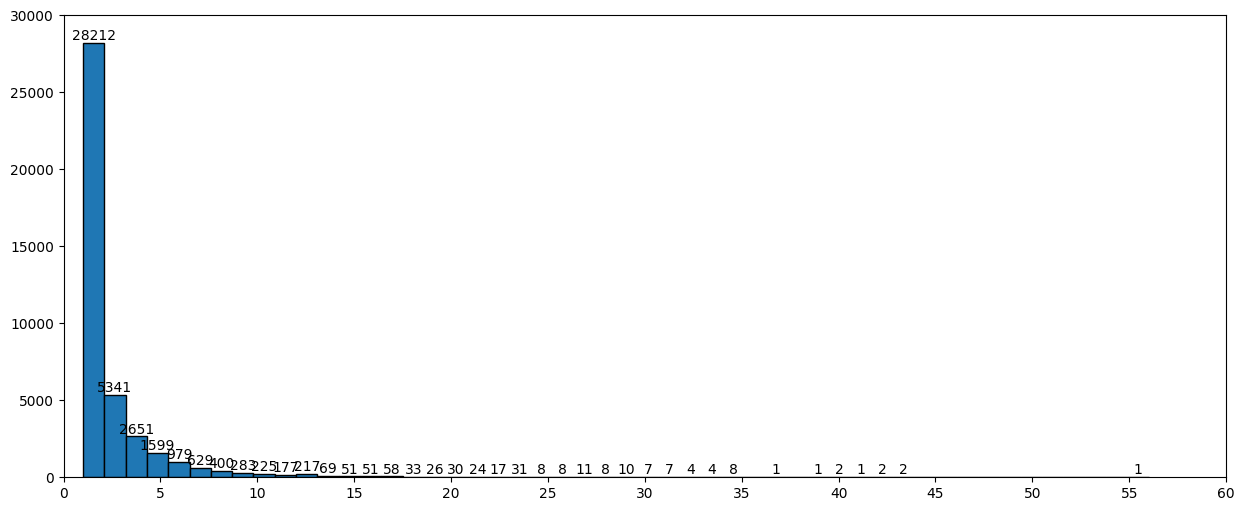

In [ ]:
# Converting all numbers to positive, following solution #3
df_campaign.campaign_calls = df_campaign.campaign_calls.abs()
print(df_campaign.campaign_calls.describe())

plt.figure(figsize=(15, 6))
counts, bins, patches = plt.hist(df_campaign.campaign_calls, bins=50, edgecolor='black')
# Add value labels
for count, bin_edge in zip(counts, bins[:-1]):
    if count > 0:
        plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')
plt.xticks(range(0, 61, 5))
plt.axis([0, 60, 0, 30000])
plt.show()

## Part 2b - Data Cleaning: Harish's Part

### Marital Status
---
Normal, no cleaning required

---

In [ ]:
df_marital = df_campaign.copy()
df_marital.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,cellular,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,cellular,2,999,no


Number of null values in marital_status column: 0
marital_status
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64


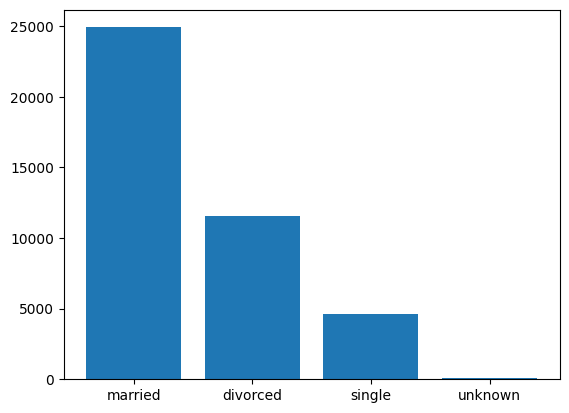

In [ ]:
# Unique values of marital status show no overlap in categorization, so no change is necessary
# No nulls in column
# Normal OHE for this column in pipeline
print(f"Number of null values in marital_status column: {df_marital.marital_status.isna().sum()}")
print(df_marital.marital_status.value_counts())
plt.bar(df_marital.marital_status.unique(), df_marital.marital_status.value_counts())
plt.show()

### Previous Contact Days
---
Over 95% of values were set to 999
- Added new boolean column denoting 999 as 'not previously contacted'
---

In [ ]:
# Model card mentions that 999 means no prior contact, identifying existence of 999 as a value
df_pdays = df_campaign.copy()
df_pdays.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,subscription_status
0,57,False,technician,married,high.school,no,no,yes,cellular,1,999,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,36,False,admin.,married,high.school,no,no,no,telephone,4,999,no
4,27,False,housemaid,married,high.school,no,None,no,cellular,2,999,no


In [ ]:
# All the rows in the head showed 999, need to check if there are normal values
df_pdays['previous_contact_days'].describe()

count    41188.000000
mean       962.475454
std        186.910907
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: previous_contact_days, dtype: float64

In [ ]:
# Normal values do exist, but it's a very small percentage
df_pdays[df_pdays['previous_contact_days'] < 999]['previous_contact_days'].describe()

count    1515.000000
mean        6.014521
std         3.824906
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        27.000000
Name: previous_contact_days, dtype: float64

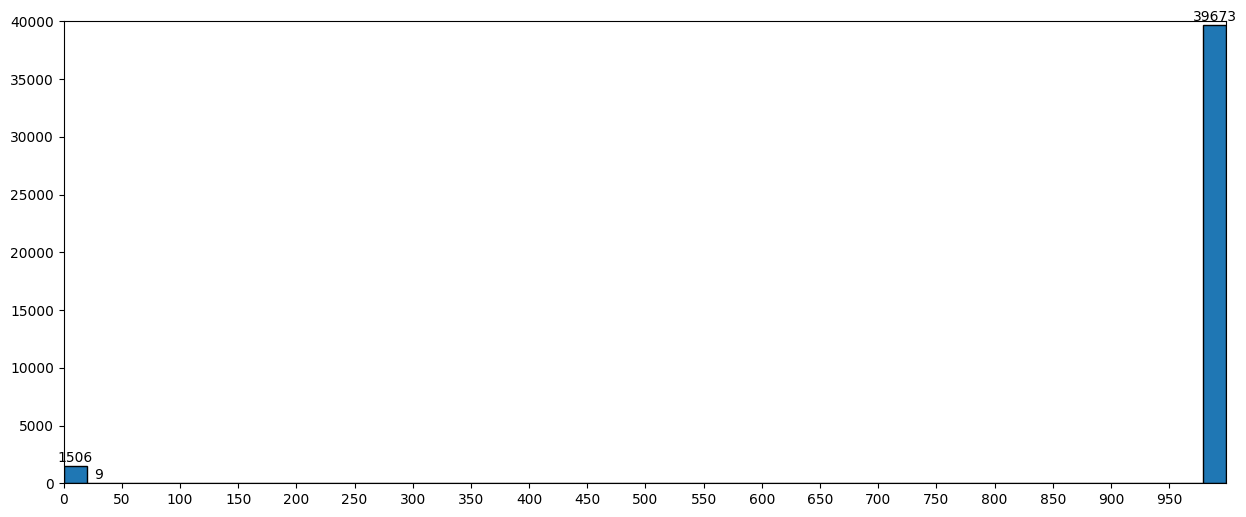

In [ ]:
plt.figure(figsize=(15, 6))
counts, bins, patches = plt.hist(df_pdays.previous_contact_days, bins=50, edgecolor='black')
# Add value labels
for count, bin_edge in zip(counts, bins[:-1]):
    if count > 0:
        plt.text(bin_edge + (bins[1] - bins[0]) / 2, count+100, str(int(count)), ha='center', va='bottom')
plt.xticks(range(0, 999, 50))
plt.axis([0, 999, 0, 40000])
plt.show()

In [ ]:
df_pdays.insert(loc=df_pdays.columns.get_loc("previous_contact_days")+1, column="previously_contacted", value=df_pdays.previous_contact_days.map(lambda x: False if x == 999 else True))
# Just to check whether correct booleans were added for values of below 999 and 999 respectively
df_pdays[df_pdays['previous_contact_days'] < 999].head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,previously_contacted,subscription_status
42,25,False,student,single,high.school,no,yes,no,cellular,1,3,True,yes
53,24,False,admin.,married,basic.9y,no,None,no,cellular,1,10,True,yes
58,41,False,admin.,divorced,university.degree,no,yes,None,cellular,2,6,True,yes
91,25,False,student,single,high.school,no,yes,no,cellular,1,6,True,no
137,31,False,admin.,married,university.degree,no,None,no,cellular,2,13,True,yes


In [ ]:
# Make 999 into -1 to fix the bad skewing of the data and also make it obvious it's not in normal range
df_pdays.previous_contact_days = df_pdays.previous_contact_days.apply(lambda x: x if x < 999 else -1)
df_pdays[df_pdays['previous_contact_days'] == -1].head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,previously_contacted,subscription_status
0,57,False,technician,married,high.school,no,no,yes,cellular,1,-1,False,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,-1,False,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,-1,False,no
3,36,False,admin.,married,high.school,no,no,no,telephone,4,-1,False,no
4,27,False,housemaid,married,high.school,no,None,no,cellular,2,-1,False,no


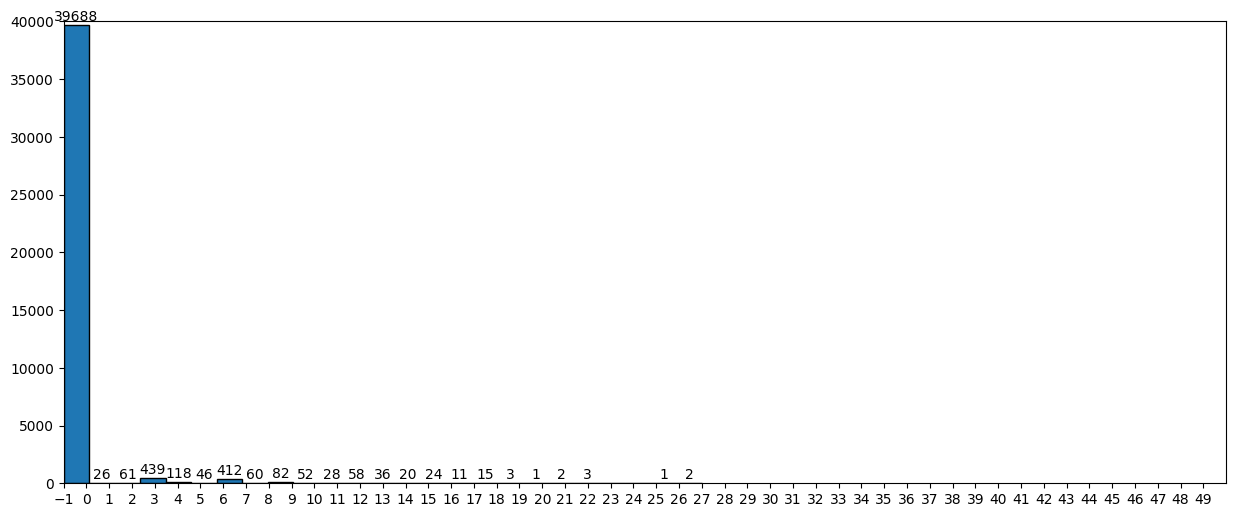

In [ ]:
plt.figure(figsize=(15, 6))
counts, bins, patches = plt.hist(df_pdays.previous_contact_days, bins=25, edgecolor='black')
# Add value labels
for count, bin_edge in zip(counts, bins[:-1]):
    if count > 0:
        plt.text(bin_edge + (bins[1] - bins[0]) / 2, count+100, str(int(count)), ha='center', va='bottom')
plt.xticks(range(-1, 50))
plt.axis([-1, 50, 0, 40000])
plt.show()

### Credit Default
---
Category of 'yes' only has three instances across all rows

---

In [ ]:
df_credit = df_pdays.copy()
df_credit.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,previously_contacted,subscription_status
0,57,False,technician,married,high.school,no,no,yes,cellular,1,-1,False,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,-1,False,no
2,33,False,blue-collar,married,basic.9y,no,no,no,cellular,1,-1,False,no
3,36,False,admin.,married,high.school,no,no,no,telephone,4,-1,False,no
4,27,False,housemaid,married,high.school,no,None,no,cellular,2,-1,False,no


credit_default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64


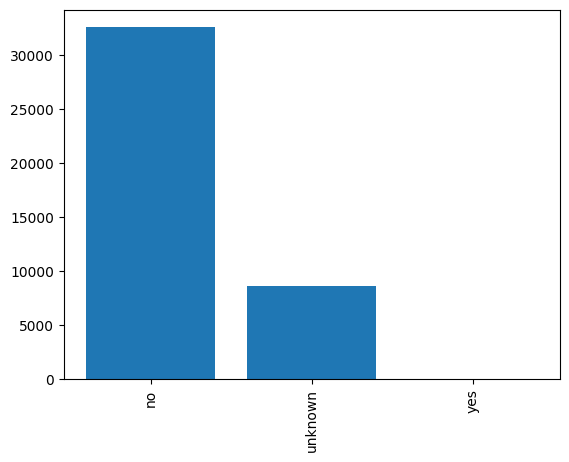

In [ ]:
# Extremely low number of yes values
print(df_credit.credit_default.value_counts())
plt.bar(df_credit.credit_default.value_counts().index, df_credit.credit_default.value_counts().values)
plt.xticks(rotation=90)
plt.show()

While this column sounds very helpful for predicting the target, the fact there are only three 'yes' values poses an issue when it comes to training the model. For one, there is a very high risk of overfitting using the 'yes' value, especially for tree models which could potentially create a split purely based on the 'yes' value and falsify its learning.

The solution to this is to consider the other valuable information that can be gathered from this column, which is whether the value is known or unknown. While this may seem less directly relevant to predicting the 'subscribed' target column, it could actually be helpful. One example: If the bank has more information on the client, they could potentially pitch better to them during the campaign call and convince them easier. While this may not be true, this information is still worth letting the model learn from as it can simply choose to not use the information if it is truly irrelevant.

credit_default
known      32591
unknown     8597
Name: count, dtype: int64


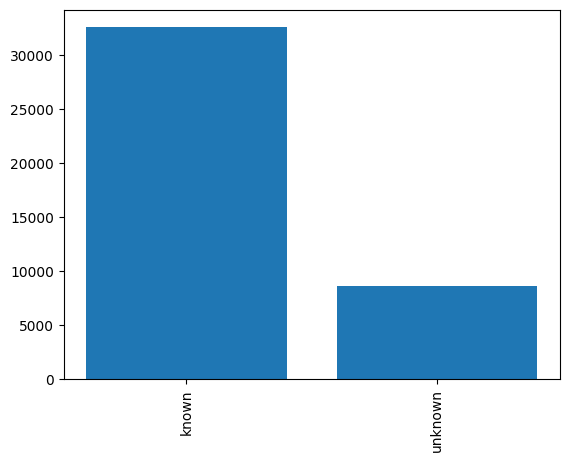

In [ ]:
# Combine 'yes' and 'no' into 'known'
df_credit.credit_default = df_credit.credit_default.apply(lambda x: x if x == "unknown" else "known")
print(df_credit.credit_default.value_counts())
plt.bar(df_credit.credit_default.value_counts().index, df_credit.credit_default.value_counts().values)
plt.xticks(rotation=90)
plt.show()

### Housing Loan
---
Extremely large (>60%) of null values
- Fill null values with 'missing'

---

In [ ]:
df_housing = df_credit.copy()
df_housing.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,previously_contacted,subscription_status
0,57,False,technician,married,high.school,known,no,yes,cellular,1,-1,False,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,-1,False,no
2,33,False,blue-collar,married,basic.9y,known,no,no,cellular,1,-1,False,no
3,36,False,admin.,married,high.school,known,no,no,telephone,4,-1,False,no
4,27,False,housemaid,married,high.school,known,None,no,cellular,2,-1,False,no


In [ ]:
print(f"Number of null values in housing_loan column: {df_housing.housing_loan.isna().sum()}")
print(df_housing.housing_loan.unique())

Number of null values in housing_loan column: 24789
['no' 'yes' None 'unknown']


housing_loan
missing    24789
yes         8595
no          7411
unknown      393
Name: count, dtype: int64


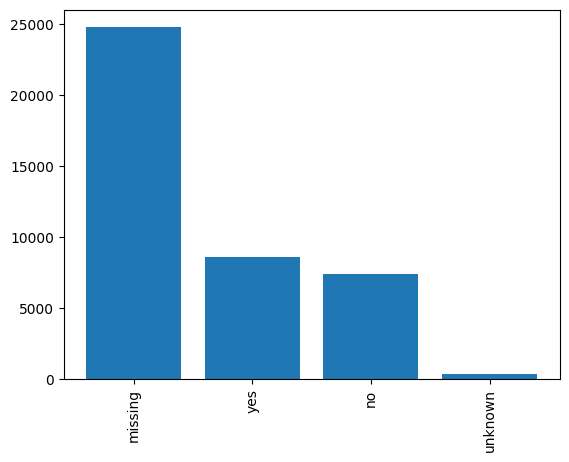

In [ ]:
# Large amount of null values, fill with string 'mssing' instead (to allow plotting without error)
df_housing.housing_loan = df_housing.housing_loan.fillna("missing")
print(df_housing.housing_loan.value_counts())
plt.bar(df_housing.housing_loan.value_counts().index, df_housing.housing_loan.value_counts().values)
plt.xticks(rotation=90)
plt.show()

Why no imputation/dropping?
- Extremely high (>60%) of missing values is difficult to attempt to clean comprehensively
- Dropping rows with null values is unviable due to the scale of them
- Imputation is also very likely to introduce noise as there is not enough available data to learn patterns from
- Leaving the 'missing' value inside the column is safer as the final model will more effectively learn what to do with it rather than risking introducing artificial patterns

### Personal Loan
---
Small number (~10%) of null values
- Configurable approach: Drop, fill with missing, or mode imputation

---

In [ ]:
df_personal = df_housing.copy()
df_personal.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,previously_contacted,subscription_status
0,57,False,technician,married,high.school,known,no,yes,cellular,1,-1,False,no
1,55,False,unknown,married,unknown,unknown,yes,no,telephone,2,-1,False,no
2,33,False,blue-collar,married,basic.9y,known,no,no,cellular,1,-1,False,no
3,36,False,admin.,married,high.school,known,no,no,telephone,4,-1,False,no
4,27,False,housemaid,married,high.school,known,missing,no,cellular,2,-1,False,no


In [ ]:
print(f"Number of null values in personal_loan column: {df_personal.personal_loan.isna().sum()}")
# fillna for plotting, same as housing loan
df_personal.personal_loan = df_personal.personal_loan.fillna("missing")
print(df_personal.personal_loan.unique())

Number of null values in personal_loan column: 4146
['yes' 'no' 'missing' 'unknown']


personal_loan
no         30532
yes         5633
missing     4146
unknown      877
Name: count, dtype: int64


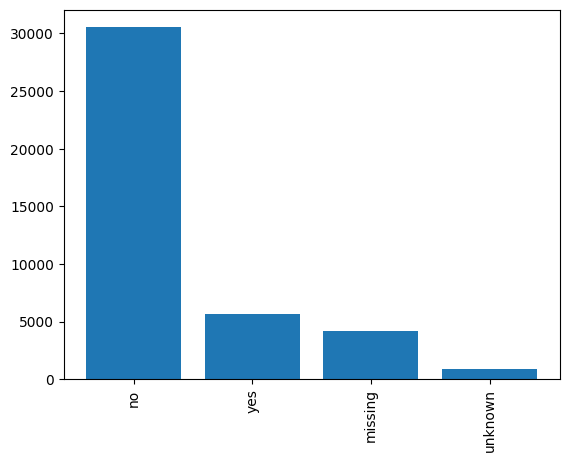

In [ ]:
print(df_personal.personal_loan.value_counts())
plt.bar(df_personal.personal_loan.value_counts().index, df_personal.personal_loan.value_counts().values)
plt.xticks(rotation=90)
plt.show()

Personal Loan has better options than just keeping the null values as missing, due to the fact that not that much data is missing. Dropping all the data will not be as destructive as the housing loan column, and imputation is likely safer as less of the data will be artificial and it won't destroy the real distribution if imputed values are inaccurate.

When it comes to imputation, mode imputation is the method that will be used. This is because 'no' is already te highest percentage value and there is little missing data, so filling all missing data with 'no' will also not disturb the distribution too much. It is also riskier to attempt to impute it using other columns like the age column because this column has less obvious correlation with other columns.

However, it's hard to predict which of the three methods (keep as missing, drop rows and imputing data) would be the best method. All of these methods will be available in the kedro pipeline to be chosen via a paramter in the parameters.yml file.

## Age Imputation
---

The goal is to determine whether age can be imputed based on data from other columns

---

In [ ]:
# Function to check one way ANOVA between integer column and categorical column
def get_one_way_anova(numerical_col: str, categorical_col: str, df: pd.DataFrame):
    # Create list of numerical values for each category
    groups = [unique for unique in df[categorical_col].unique() if unique not in ["unknown"]]
    group_data = [df[df[categorical_col] == g][numerical_col].dropna().to_list() for g in groups]

    # Calculate one way anova
    f_stat, p_val = stats.f_oneway(*group_data, equal_var=False)
    return f_stat, p_val

# Function to get categorical distribution for a numerical column
def get_cat_distribution(numerical_col: str, categorical_col: str, df: pd.DataFrame):
    # Create list of numerical values for each category
    groups = [unique for unique in df[categorical_col].unique() if unique not in ["unknown", None]]
    group_data = [df[df[categorical_col] == g][numerical_col].dropna().to_list() for g in groups]
    print(groups)

    # Plot histogram based on data points
    fig, axes = plt.subplots(1, len(group_data), figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.hist(group_data[i], bins=25, density=True)
        ax.set_title(groups[i])
    return fig

# Determine if normally distributed
def get_kwh_test(numerical_col: str, categorical_col: str, df: pd.DataFrame):
    # Create list of numerical values for each category
    groups = [unique for unique in df[categorical_col].unique() if unique not in []]
    group_data = [df[df[categorical_col] == g][numerical_col].dropna().to_list() for g in groups]

    # Calculate Kruskal-Wallis H test
    f_stat, p_val = stats.f_oneway(*group_data, equal_var=False)
    return f_stat, p_val

In [ ]:
df_age_impute = df_personal.copy()

# Modify dataframe to make it compatible with ANOVA
df_age_impute.occupation = df_age_impute.occupation.map(lambda cat: cat.lower().replace(".", ""))
df_age_impute.education_level = df_age_impute.education_level.map(lambda cat: cat.lower().replace(".", "_"))
df_age_impute.age = df_age_impute.age.map(lambda x: np.nan if x == -1 else x)
df_age_impute.head()

,age,age_unk,occupation,marital_status,education_level,credit_default,housing_loan,personal_loan,contact_method,campaign_calls,previous_contact_days,previously_contacted,subscription_status
0,57.0,False,technician,married,high_school,known,no,yes,cellular,1,-1,False,no
1,55.0,False,unknown,married,unknown,unknown,yes,no,telephone,2,-1,False,no
2,33.0,False,blue-collar,married,basic_9y,known,no,no,cellular,1,-1,False,no
3,36.0,False,admin,married,high_school,known,no,no,telephone,4,-1,False,no
4,27.0,False,housemaid,married,high_school,known,missing,no,cellular,2,-1,False,no


In [ ]:
get_one_way_anova("age", "housing_loan", df_age_impute)

(np.float64(0.8669524881164513), np.float64(0.42025270301927686))

In [ ]:
# Plots all columns as histograms, omitted since output is very long.
# Based on observations it is safe to say that

# for column in df_age_impute:
#     if column in ["age", "age_unk", "subscriber_status"]:
#         continue
#     get_cat_distribution("age", column, df_age_impute)
#     plt.show()

In [ ]:
df_age_impute.credit_default.unique()

array(['known', 'unknown'], dtype=object)

In [ ]:
p_result = {"column": [], "p_value": [], "f_statistic": []}
# These ignore columns should have nothing to do with age at all
ignore_columns = ["age", "age_unk", "subscription_status", "campaign_calls", "previous_contact_days", "previously_contacted"]
for column in df_age_impute:
    if column in ignore_columns:
        continue
    
    f_stat, p_val = get_kwh_test("age", str(column), df_age_impute)
    p_result["column"].append("age_" + str(column))
    p_result["p_value"].append(p_val)
    p_result["f_statistic"].append(f_stat)

p_results_df = pd.DataFrame(p_result)
p_results_df

,column,p_value,f_statistic
0,age_occupation,0.000000e+00,1285.763227
1,age_marital_status,5.214573e-254,3319.242070
2,age_education_level,4.414374e-133,298.680477
3,age_credit_default,2.526063e-239,1137.984151
4,age_housing_loan,6.137324e-01,0.601989
5,age_personal_loan,8.433407e-01,0.275184
6,age_contact_method,1.042432e-01,2.639547


Explanation & Thought Process:

With many missing values in the age column, the goal here is to impute the missing values using the data
contained in the other columns. The reason why I think this may be possible for the age column is due to
the fact that it may be possible to impute age based on data such as their occupation or marital status.

The first step to decide which columns' data I would use for the imputation is through the one-way ANOVA
method, which tests whether the means of several independent categories have statistically significant
differences. This can help to determine whether the specified categories have an influence on a dependent
numerical (integer) value, in this case being the age column.

I did this by splitting a data column, for example: marital_status into its unique categories (married, 
single, divorced), before finding all the ages associated with this category. From there, I can caluclate
the one way anova using scipy.stats.f_oneway(). However, upon observation of the histograms of each
category inside each of the data columns, I realised that the data does not fulfil some of the requirements 
of using the one-way ANOVA test. The first requirement being that the dependent variable (age) should be 
normally distributed across all sample groups (categories). The second being that the variances should be
roughly equal across all groups.

Hence, I decided to use a non-parametric version of one-way anova, called the Kruskal-Wallis Test, which
instead determines if the medians of several independent categories have statistically significant
differences. I implemented this test using scipy.stats.kruskal()


Application:

I looped through the likely candidate columns that may affect the age column, which were everything except
age, subscriber_status. campaign_calls and previous_contact_days were not test because they were numerical
columns and hence would break one requirement of the test, which was that each group needed at least 5
observations. This was in conjunction with the fact that these data points should not affect the age except
through dubious / coincidental statistical correlation since this data is taken by the bank itself.

For the Kruskal-Wallis Test, we define 2 hypotheses:
Null Hypothesis: The population distributions / medians are all equal (no differences / no influence)
Alternative Hypothesis: At least one of the population medians / distributions are different from the others
(has influence)

If the p-value <= alpha (0.05) we can safely reject the null hypothesis. If the p-value > alpha, we will
fail to reject the null hypothesis.

As seen in the above p-values, there are 4 columns that have the potential to help with the imputation of 
unknown values in the age column. These 4 columns being occupation, marital_status, education_level, and 
credit_defaut. This is because their p-value is less than our alpha (set at 0.05) and thus we can reject
the null hypothesis for these columns. This means that these 4 columns are likely to have an influence
on the age specified in the age column. Thus, I will use these columns for imputation via KNN.

### Imputation

In [ ]:
df_age_impute_mean = df_personal.copy()
print(df_age_impute_mean.loc[df_age_impute_mean.age == -1].shape[0])

# NOTE: Including unknown values in the data does not negatively affect final distribution
# df_age_impute_mean.drop(df_age_impute_mean[df_age_impute_mean["marital_status"] == "unknown"].index, inplace=True)
# df_age_impute_mean.drop(df_age_impute_mean[df_age_impute_mean["occupation"] == "unknown"].index, inplace=True)
# df_age_impute_mean.drop(df_age_impute_mean[df_age_impute_mean["education_level"] == "unknown"].index, inplace=True)

df_age_impute_mean = df_age_impute_mean.iloc[:, [0, 2, 3, 4, 5]]
print(df_age_impute_mean.loc[df_age_impute_mean.age == -1].shape[0])

4197
4197


In [ ]:
# Imputing the data 
df_age_impute_ohe = pd.get_dummies(df_age_impute_mean, ["occupation", "marital_status", "education_level", "credit_default"])
df_age_impute_ohe.age = df_age_impute_ohe.age.map(lambda x: x if x != -1 else np.nan)
df_age_impute_ohe.age.isnull().sum()

imputer = KNNImputer(n_neighbors=2, weights="distance")
imputed_data = imputer.fit_transform(df_age_impute_ohe.reset_index().drop("index", axis=1))

imputed_df = pd.DataFrame(imputed_data, columns=df_age_impute_ohe.columns, index=df_age_impute_ohe.index)
imputed_df.head()

Original Data (No -1s)
count    36991.000000
mean        40.025303
std         10.436777
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: age, dtype: float64

Imputed Data
count    41188.000000
mean        39.994392
std         10.281434
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: age, dtype: float64


0    57
1    55
2    33
3    36
4    27
Name: age, dtype: int64

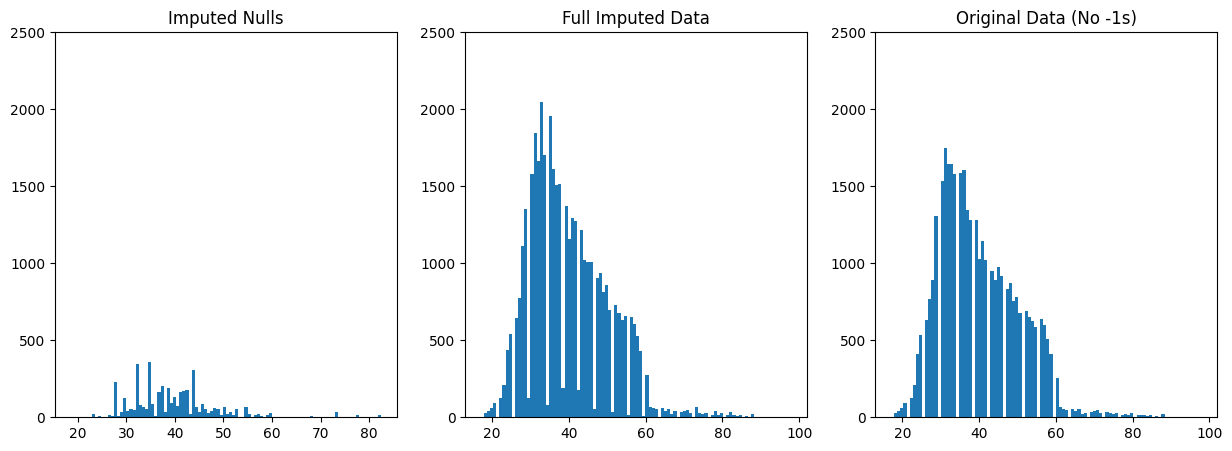

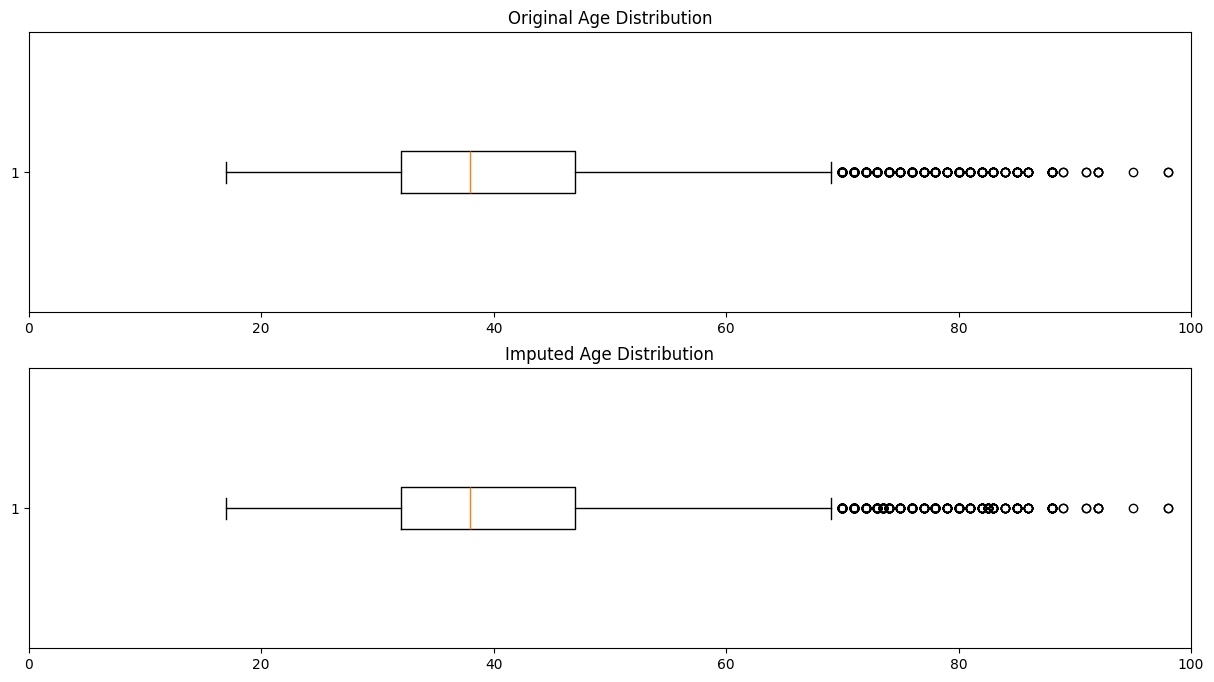

In [ ]:
# Based on graphs and describe() below, the overall distribution, IQR, mean, std are very similar to the original datasets (respectively).
# With this it is safe to assume that the imputation of the age column was successful
# It was not possible to test distribution similarity since the KS test requires continuous distributions (original is not coninuous)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(imputed_df.loc[df_age_impute_ohe.loc[df_age_impute_ohe.age.isnull()].index].age, bins=100)
ax[1].hist(imputed_df.age, bins=100)
ax[2].hist(df_age_impute_ohe.age, bins=100)
ax[0].set_title("Imputed Nulls")
ax[1].set_title("Full Imputed Data")
ax[2].set_title("Original Data (No -1s)")
for x in ax:
    x.set_ylim(0, 2500)
plt.plot()

fig, ax = plt.subplots(2, 1, figsize=(15, 8))
ax[0].boxplot(df_age_impute_ohe.loc[df_age_impute_ohe.age.isna() == False].age, vert=False)
ax[1].boxplot(imputed_df.age, vert=False)
ax[0].set_title("Original Age Distribution")
ax[1].set_title("Imputed Age Distribution")
for x in ax:
    x.set_xlim(0, 100)
plt.plot()

print("Original Data (No -1s)")
print(df_age_impute_ohe.loc[df_age_impute_ohe.age.isna() == False].age.describe())
print("\nImputed Data")
print(imputed_df.age.describe())

df_final_age_imputed = imputed_df.age.astype(int)
# Change age to reflect new imputed data
df_final_age_imputed.head()

## Part 3 - Bivariate Analysis
---
Purpose
- Check out how each feature could help in predicting the target column
- Identify targets for feature selection/engineering if needed

---

In [ ]:
df_cleaned = df_personal.copy()
df_cleaned.subscription_status = df_cleaned.subscription_status.apply(lambda x: True if x == "yes" else False)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    41188 non-null  int64 
 1   age_unk                41188 non-null  bool  
 2   occupation             41188 non-null  object
 3   marital_status         41188 non-null  object
 4   education_level        41188 non-null  object
 5   credit_default         41188 non-null  object
 6   housing_loan           41188 non-null  object
 7   personal_loan          41188 non-null  object
 8   contact_method         41188 non-null  object
 9   campaign_calls         41188 non-null  int64 
 10  previous_contact_days  41188 non-null  int64 
 11  previously_contacted   41188 non-null  bool  
 12  subscription_status    41188 non-null  bool  
dtypes: bool(3), int64(3), object(7)
memory usage: 3.3+ MB


: 

### Age

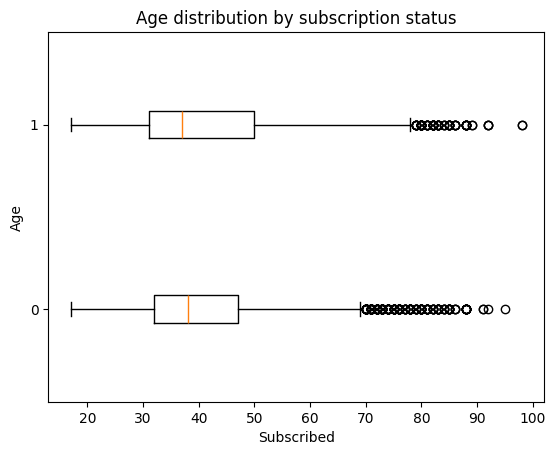

: 

In [ ]:
# Eyeballing it the only difference seems to be visible at older ages that are
# already outliers as known from the univariate analysis
df_temp_age_cleaned = df_cleaned[df_cleaned['age'] != -1]

plt.figure()
plt.boxplot(
    [df_temp_age_cleaned[df_temp_age_cleaned.subscription_status == v].age
     for v in [0, 1]],
    tick_labels=["0", "1"],
    vert=False
)
plt.ylabel("Age")
plt.xlabel("Subscribed")
plt.title("Age distribution by subscription status")
plt.show()


In [ ]:
# There seems to be only a very small increase in the mean age for those who subscribed
# There is no direct correlation between age and subscription status
# While the model can potentially gain insights from it, it is hard to tell whether it'll be helpful
print("Subscribed = True")
df_temp_age_cleaned = df_cleaned[df_cleaned['age'] != -1]
print(df_temp_age_cleaned[df_temp_age_cleaned.subscription_status == True].age.describe())
print("\nSubscribed = False")
print(df_temp_age_cleaned[df_temp_age_cleaned.subscription_status == False].age.describe())

Subscribed = True
count    4191.00000
mean       40.93486
std        13.90226
min        17.00000
25%        31.00000
50%        37.00000
75%        50.00000
max        98.00000
Name: age, dtype: float64

Subscribed = False
count    32800.000000
mean        39.909085
std          9.901279
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         95.000000
Name: age, dtype: float64


: 

### Occupation

In [ ]:
# Making a generic helper function to help with bivariate analysis
def bivariate_categorical_plotter(df, colname):
    prop = df.groupby(colname)["subscription_status"].mean()

    plt.figure()
    plt.bar(prop.index, prop.values)
    plt.ylabel("Proportion subscribed")
    plt.xlabel(colname)
    plt.xticks(rotation=45)
    plt.title("Probability of subscribing by Category")
    plt.show()

: 

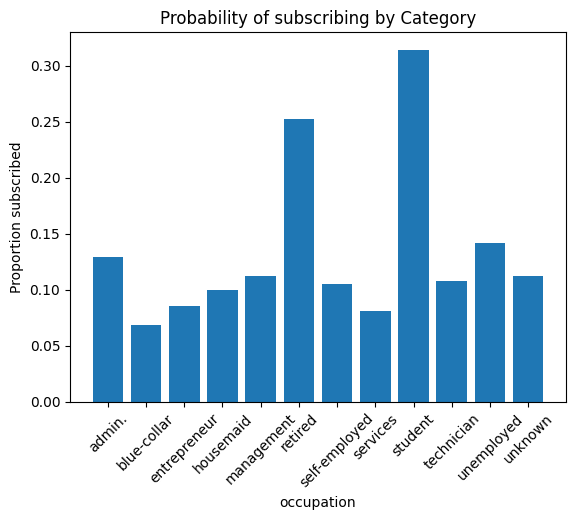

: 

In [ ]:
# Looks to be a very good feature, as there are clear differences in the proportion of
# people who subscribe based on their occupation.
bivariate_categorical_plotter(df_cleaned, "occupation")

### Education Level

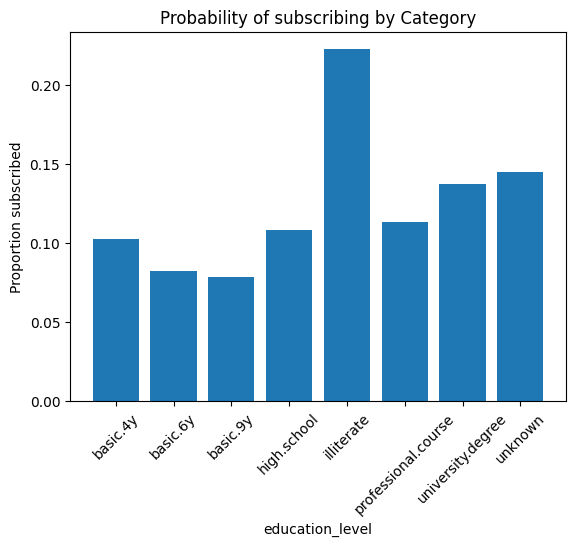

: 

In [ ]:
# This feature also shows potential
# Small caveat is that the 'illiterate' value was a rare value as known from univariate analysis,
# so that obvious probability jump can't be taken advantage of too much by the model
bivariate_categorical_plotter(df_cleaned, "education_level")

### Contact Method

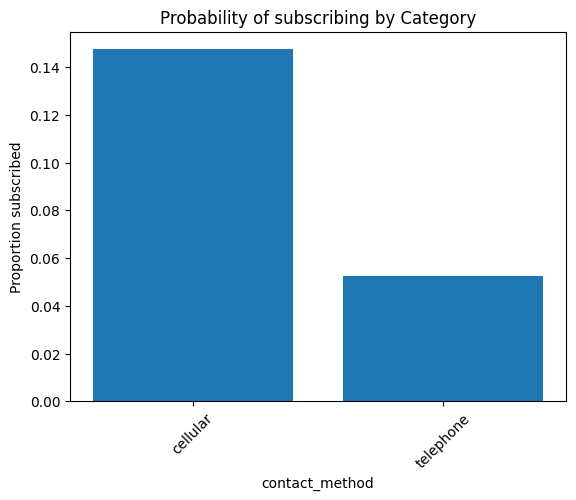

: 

In [ ]:
# Quite a large difference between the probability of subscribing for both contact methods
# Furthermore, both contact methods each share a large proportion of the data
# That makes this feature very helpful due to the large split
bivariate_categorical_plotter(df_cleaned, "contact_method")

### Campaign Calls

Text(0.5, 1.0, 'Status of subscribing by Campaign Calls')

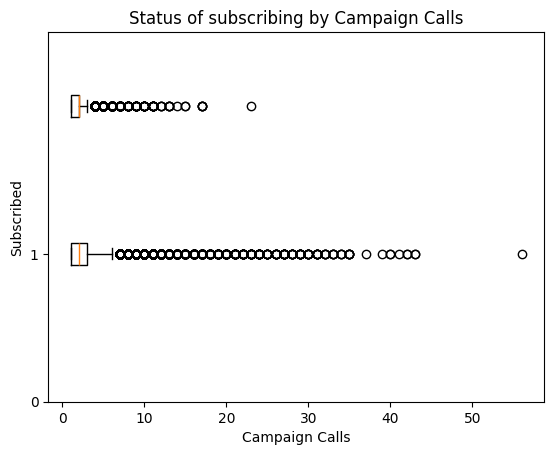

: 

In [ ]:
# This feature is harder to make sense of, but my first guess is that after a certain
# amount of calls, calling them more is very unlikely to change their mind
plt.boxplot(
    [df_cleaned[df_cleaned.subscription_status == v].campaign_calls
     for v in [0, 1]],
    tick_labels=["0", "1"],
    vert=False
)
plt.yticks([0, 1])
plt.ylabel("Subscribed")
plt.xlabel("Campaign Calls")
plt.title("Status of subscribing by Campaign Calls")

### Marital Status

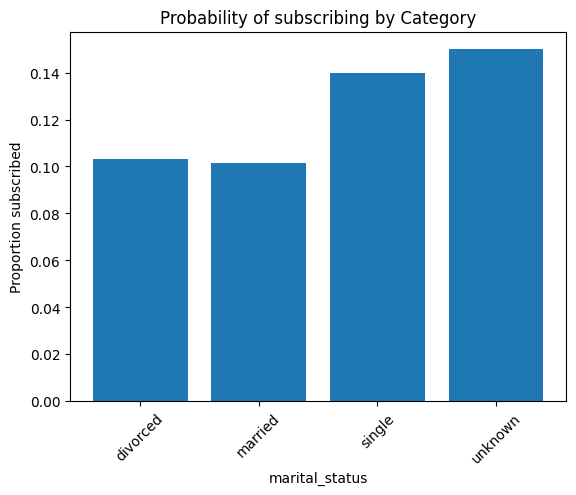

: 

In [ ]:
# This one is weird because it is hard to interpret why 'unknown' could possibly have
# the highest proportion of subscribing. But there were very few unknown values so this
# could just be a less stable column. Still a helpful feature as it shows single people
# are more likely to subscribe over people who are or were married.
bivariate_categorical_plotter(df_cleaned, "marital_status")

### Previous Contact Days

Text(0.5, 1.0, 'Status of subscribing by Previous Contact Days')

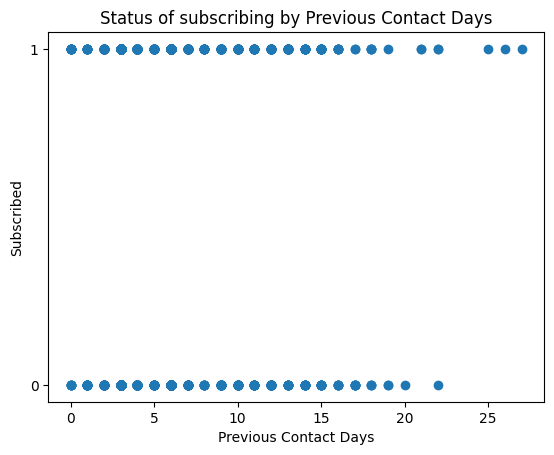

: 

In [ ]:
# Doesn't look like a helpful feature
# From univariate analysis we know that only about 5% of values were normal,
# which means it's likely that even the slightly higher mean we can see in
# those who subscribed is just due to the lack of data swaying results
# This could lead to overfitting, might be a good idea to drop it
df_temp_pdays_cleaned = df_cleaned[df_cleaned['previous_contact_days'] != -1]

plt.figure()
plt.scatter(df_temp_pdays_cleaned.previous_contact_days, df_temp_pdays_cleaned.subscription_status)
plt.yticks([0, 1])
plt.ylabel("Subscribed")
plt.xlabel("Previous Contact Days")
plt.title("Status of subscribing by Previous Contact Days")

### Credit Default

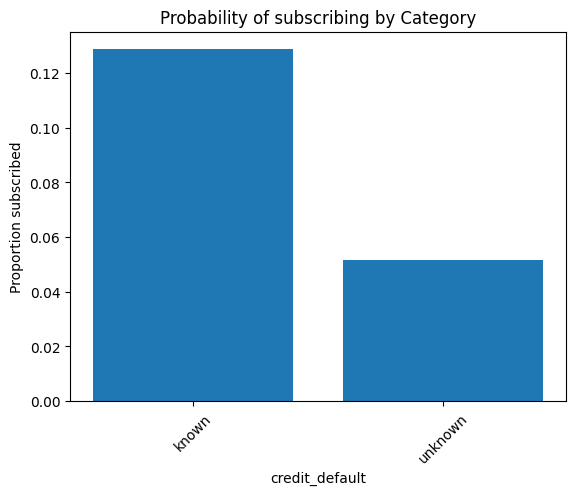

: 

In [ ]:
# Overall seems to be a helpful feature, not much to say about it
# Obvious jump in subscription probability for those who have a known status
bivariate_categorical_plotter(df_cleaned, "credit_default")

### Housing Loan

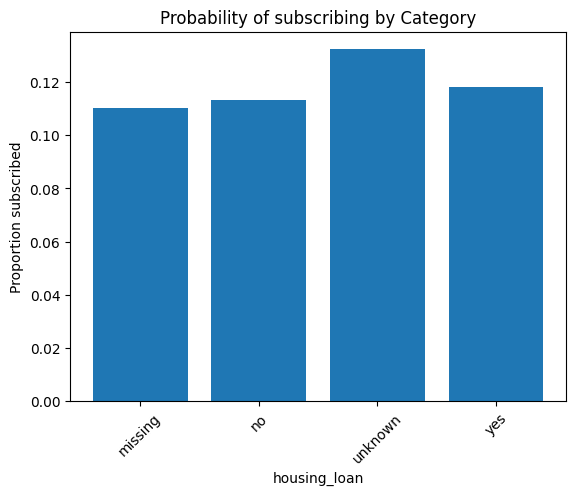

: 

In [ ]:
# Very small differences in probability
# Similar to Marital Status, the small amount of unknown values might have an unstable value
# and hence is hard to interpret
# The values that are easy to assume that are the most helpful, which are yes and no,
# seem to have the smallest difference in probability
# Not sure if this entire feature is worth keeping, when we already know 60% of the data is missing
# and the non-missing data seems to not help too much
bivariate_categorical_plotter(df_cleaned, "housing_loan")

### Personal Loan

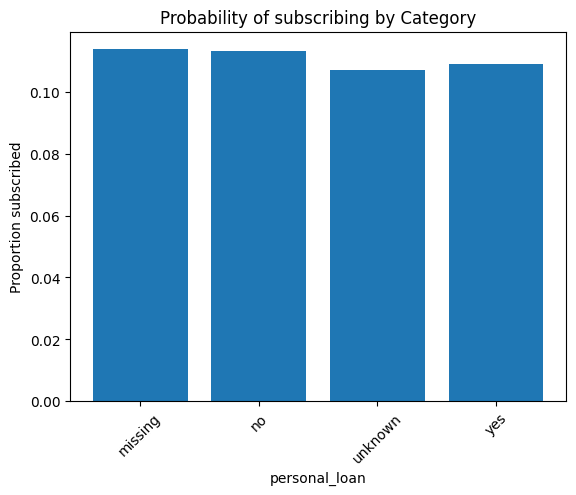

: 

In [ ]:
# Similar to housing loan, there are very small differences in probability
# This column might also be worth removing as a feature as it could potentially just be noise
bivariate_categorical_plotter(df_cleaned, "personal_loan")

## Part 4 - Feature Engineering
---
Purpose
- Rank features and select ones that are more likely to be use for the model
- Create new features from existing features if possible to create new, relevant information

---

### The Loan Columns

The two loan columns are the first target for this section as at first glance, these two columns did not seem like they would be individually strong for predicting the target.

Since both loan columns are primarily boolean values, one possible feature to engineer would be whether the client is confirmed to have at least one loan.

In [ ]:
df_features = df_cleaned.copy()
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    41188 non-null  int64 
 1   age_unk                41188 non-null  bool  
 2   occupation             41188 non-null  object
 3   marital_status         41188 non-null  object
 4   education_level        41188 non-null  object
 5   credit_default         41188 non-null  object
 6   housing_loan           41188 non-null  object
 7   personal_loan          41188 non-null  object
 8   contact_method         41188 non-null  object
 9   campaign_calls         41188 non-null  int64 
 10  previous_contact_days  41188 non-null  int64 
 11  previously_contacted   41188 non-null  bool  
 12  subscription_status    41188 non-null  bool  
dtypes: bool(3), int64(3), object(7)
memory usage: 3.3+ MB


: 

In [ ]:
df_features['known_loan'] = df_features.apply(lambda x: "yes" if (x.housing_loan == "yes") \
                                           or (x.personal_loan == "yes") \
                                            else "no", axis=1)
df_features.known_loan.describe()

count     41188
unique        2
top          no
freq      28292
Name: known_loan, dtype: object

: 

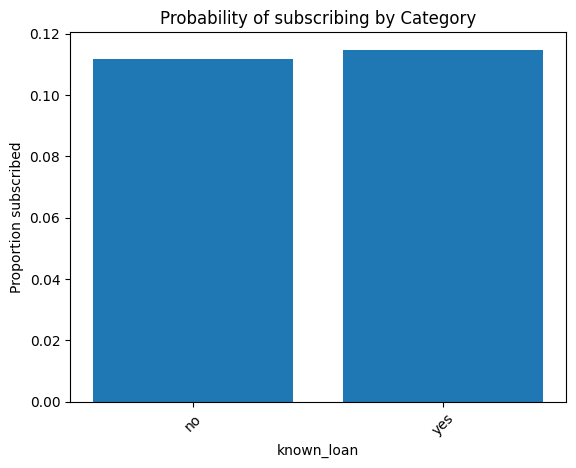

: 

In [ ]:
bivariate_categorical_plotter(df_features, "known_loan")

In [ ]:
df_features['known_no_loan'] = df_features.apply(lambda x: "no" if (x.housing_loan == "no") \
                                           and (x.personal_loan == "no") \
                                            else "yes", axis=1)
df_features.known_no_loan.describe()

count     41188
unique        2
top         yes
freq      35471
Name: known_no_loan, dtype: object

: 

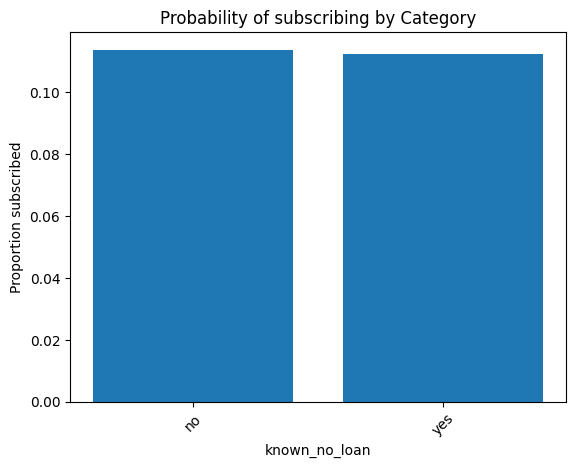

: 

In [ ]:
bivariate_categorical_plotter(df_features, "known_no_loan")

Both attempts at making a new feature ('known_loan' amd 'known_no_loan') were clearly unsuccesful, and are nearly irrelevant as individual features at predicting subscription status. This further shows that the loan columns have among the weakest individual correlation with the target, and while they might be better when combined with other features, they are good targets for removing from the features input into the model to reduce noise.

### Occupation

From bivariate analysis, it was noticed that rows with 'student' and 'retired' in the occupation column had the highest probability of subscribing with quite a big jump over all the other values which were normal jobs. This could potentially be leveraged to make a new, simple column that the model can use easily.

In [ ]:
df_features['employed'] = df_features.apply(lambda x: "no" if (x.occupation == "student") \
                                           or (x.occupation == "retired") \
                                            else "yes", axis=1)
df_features.employed.describe()

count     41188
unique        2
top         yes
freq      38593
Name: employed, dtype: object

: 

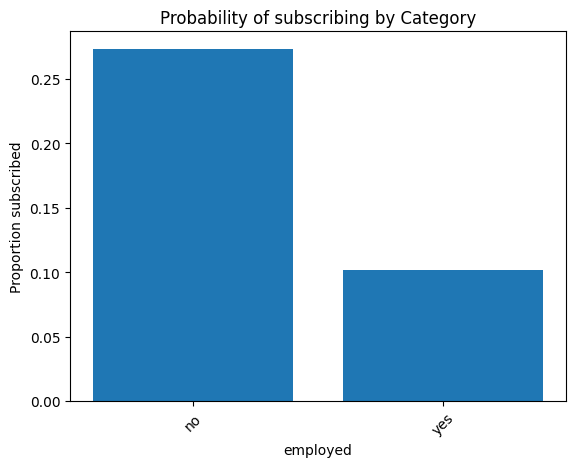

: 

In [ ]:
bivariate_categorical_plotter(df_features, "employed")

This seems to be a much more successful engineered feature. It is likely better to still keep the occupation column as a feature because there were sizeable deviations in the probability of subscribing between the different employment types, and let the model decide when to use each feature.

### Feature Selection

The goal of this section is to create and justify an arbitrary ranking of features, and create a list ordered by rank.

This feature selection is more biased as only the direct correlation between the features and the target was explored, and not complex relationships between multiple features. Hence, the feature selection must be easily configurable. The parameters.yml file will allow the user to select X number of features, where X can be any number from 1 to the maximum amount of features in the dataset. This allows us to easily test whether selecting features that we think are better will lead to better results, or whether leaving every feature in and letting the model figure it out would be better.

1. 'occupation'. By far has the most interpretable correlations with the subscribed column as seen from bivariate analysis.
2. 'contact_method': Another easy to understand column with an obvious probability difference between the two values.
3. 'credit_default'. Also shows a clear split between the two values for which is more likely to lead to subscription. Is not ranked higher solely because the values of 'known' and 'unknown' are less interpretable unlike how clear 'occupation' and 'employed' are.
4. 'campaign_calls'. Shows a clear signal that after a certain amount of times calling the client, they will most likely not subscribe.
5. 'marital_status'. Shows that single people are more likely to be subscribed than those who are/were married. 'unknown' value is weird but not a problem as there were only 80 of them.
6. 'education_level'. Clear probability differences across values, but even more uninterpretable by human understanding and might be influenced by imbalanced data in categories.
7. 'age'. The individual correlation with the target starts to drop more from this feature onwards.
8. 'housing_loan'. Very uninterpretable as the value with the biggest probability difference is 'unknown', with other values not showing much difference.
9. 'personal_loan'. Same issue as 'housing_loan'.

# Testing Parquet Dataset

In [ ]:
from sklearn.feature_selection import mutual_info_regression

data = df_personal.copy()
data = data[data['age'] != -1]

le = LabelEncoder()
for col in data.columns:
    if data[col].dtype == "object":
        data[col] = le.fit_transform(data[col])

X = data.iloc[:, [0, 2, 3, 4, 5, 6, 7, 8]]
y = data.iloc[:, 0]
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns)
mi_series

In [ ]:
pd.read_parquet(r"data\02_cleaned\preprocessed_bmarket.pq").head()

FileNotFoundError: [Errno 2] No such file or directory: 'data\\02_cleaned\\preprocessed_bmarket.pq'

: 

In [ ]:
pd.read_parquet(r"data\02_cleaned\preprocessed_bmarket_enc.pq").head()

,age,housing_loan,campaign_calls,previous_contact_days,previously_contacted,subscription_status,occupation_admin,occupation_blue-collar,occupation_entrepreneur,occupation_housemaid,...,education_level_university_degree,education_level_unknown,credit_default_no,credit_default_unknown,credit_default_yes,personal_loan_no,personal_loan_unknown,personal_loan_yes,contact_method_cellular,contact_method_telephone
0,57.0,0,1,999,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,True,False
1,55.0,1,2,999,False,False,False,False,False,False,...,False,True,False,True,False,True,False,False,False,True
2,33.0,0,1,999,False,False,False,True,False,False,...,False,False,True,False,False,True,False,False,True,False
3,36.0,0,4,999,False,False,True,False,False,False,...,False,False,True,False,False,True,False,False,False,True
4,27.0,-1,2,999,False,False,False,False,False,True,...,False,False,True,False,False,True,False,False,True,False


: 

In [ ]:
import pickle
m = pickle.load(open(r"saved_models\decision_tree_model_20251129_160710.pickle", "rb"))

: 

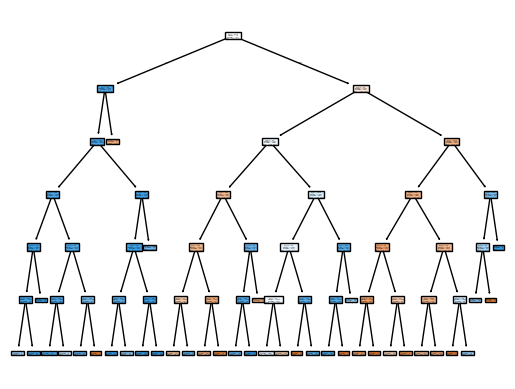

: 

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plot_tree(m, filled=True)
plt.show()